In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
with open('alice.txt', 'r', encoding='latin1') as f:
    data = f.read()
    
print("Extract: ", data[:50])
print("Length: ", len(data))

Extract:  ALICE was beginning to get very tired of sitting b
Length:  145178


In [3]:
chars = list(set(data))
indexer = {char: index for (index, char) in enumerate(chars)}

In [4]:
indexed_data = []
for c in data:
    indexed_data.append(indexer[c])
    
print("Indexed extract: ", indexed_data[:50])
print("Length: ", len(indexed_data))

Indexed extract:  [11, 61, 58, 43, 51, 32, 9, 22, 0, 32, 29, 3, 67, 36, 16, 16, 36, 16, 67, 32, 54, 19, 32, 67, 3, 54, 32, 56, 3, 66, 37, 32, 54, 36, 66, 3, 2, 32, 19, 12, 32, 0, 36, 54, 54, 36, 16, 67, 32, 29]
Length:  145178


In [5]:
def index2onehot(batch):
    
    batch_flatten = batch.flatten()
    onehot_flat = np.zeros((batch.shape[0] * batch.shape[1], len(indexer)))
    onehot_flat[range(len(batch_flatten)), batch_flatten] = 1
    onehot = onehot_flat.reshape((batch.shape[0], batch.shape[1], -1))
    
    return onehot

In [6]:
class LSTM(nn.Module):
    def __init__(self, char_length, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(char_length, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, char_length)
        
    def forward(self, x, states):
        out, states = self.lstm(x, states)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, states
    
    def init_states(self, batch_size):
        hidden = next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size).zero_()
        cell = next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size).zero_()
        states = (hidden, cell)
        
        return states 

In [7]:
n_seq = 100 ## Number of sequences per batch
seq_length =  50
n_batches = math.floor(len(indexed_data) / n_seq / seq_length)

total_length = n_seq * seq_length * n_batches
x = indexed_data[:total_length]
x = np.array(x).reshape((n_seq,-1))

In [8]:
model = LSTM(len(chars), 256, 2).to("cuda")
model

LSTM(
  (lstm): LSTM(70, 256, num_layers=2, batch_first=True)
  (output): Linear(in_features=256, out_features=70, bias=True)
)

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [10]:
losses = []
for e in range(1, epochs+1):
    states = model.init_states(n_seq)
    batch_loss = []
    
    for b in range(0, x.shape[1], seq_length):
        x_batch = x[:,b:b+seq_length]
        
        if b == x.shape[1] - seq_length:
            y_batch = x[:,b+1:b+seq_length]
            y_batch = np.hstack((y_batch, indexer["."] * np.ones((y_batch.shape[0],1))))
        else:
            y_batch = x[:,b+1:b+seq_length+1]
        
        x_onehot = torch.Tensor(index2onehot(x_batch)).to("cuda")
        y = torch.Tensor(y_batch).view(n_seq * seq_length).to("cuda")
        
        pred, states = model(x_onehot, states)
        loss = loss_function(pred, y.long())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    losses.append(np.mean(batch_loss))
    
    if e%50 == 0:
        print("epoch: ", e, "... Loss function: ", losses[-1])

epoch:  50 ... Loss function:  1.5207843986050835
epoch:  100 ... Loss function:  1.006190665836992
epoch:  150 ... Loss function:  0.5197970939093622
epoch:  200 ... Loss function:  0.24446514968214364
epoch:  250 ... Loss function:  0.0640328845073437
epoch:  300 ... Loss function:  0.007852113484565553
epoch:  350 ... Loss function:  0.003644719101681278
epoch:  400 ... Loss function:  0.006955199634078248
epoch:  450 ... Loss function:  0.0030021724242973945
epoch:  500 ... Loss function:  0.0034294885518992768


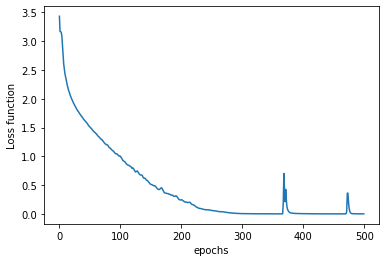

In [11]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

In [12]:
starter = "So she was considering in her own mind "
states = None
model = model.to("cpu")
for ch in starter:
    x = np.array([[indexer[ch]]])
    x = index2onehot(x)
    x = torch.Tensor(x)
    
    pred, states = model(x, states)

counter = 0
while starter[-1] != "." and counter < 100:
    counter += 1
    x = np.array([[indexer[starter[-1]]]])
    x = index2onehot(x)
    x = torch.Tensor(x)
    
    pred, states = model(x, states)
    pred = F.softmax(pred, dim=1)
    p, top = pred.topk(10)
    p = p.detach().numpy()[0]
    top = top.numpy()[0]
    index = np.random.choice(top, p=p/p.sum())
    
    starter += chars[index]
print(starter)

So she was considering in her own mind he bleatters, and lend peach of meatibly, and said to the Gryphon.
